In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data_raw = pd.read_csv(r"../input/anomaly-detection-falling-people-events/data/train/data_0.csv")
for i in range(1,20):
    d = pd.read_csv(r"../input/anomaly-detection-falling-people-events/data/train/data_{}.csv".format(i))
    data_raw.append(d)
data=data_raw.to_numpy()
faulty=[]
correct=[]
for i in range(data.shape[0]):
    if(data[i][7]==1):
        faulty.append(data[i])
    else:
        correct.append(data[i])
faulty = np.array(faulty,dtype="float32")
correct = np.array(correct,dtype="float32")
print("Failing people",faulty.shape,"Normal people",correct.shape)

Failing people (327, 8) Normal people (5478, 8)


> ***Splitting data into training,cross-validation and testing data***

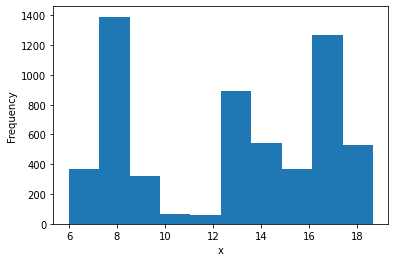

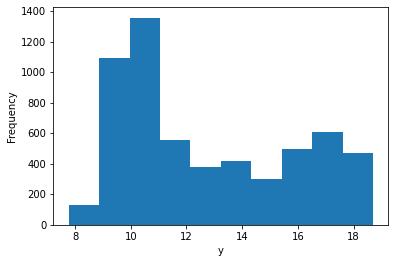

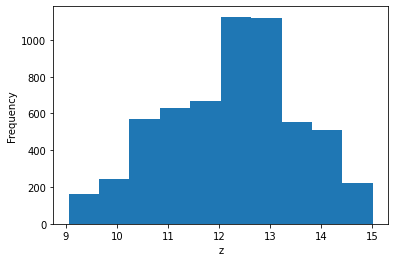

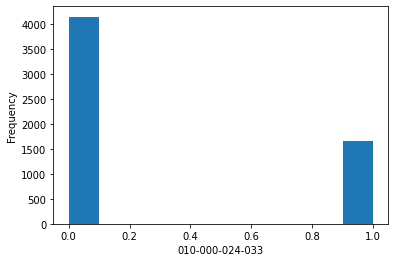

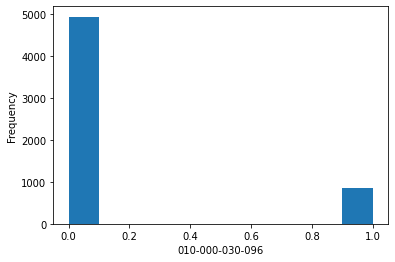

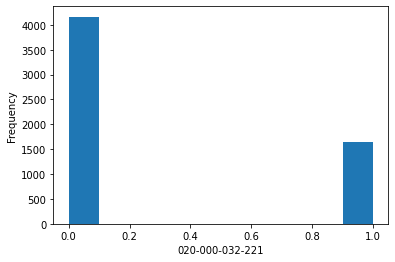

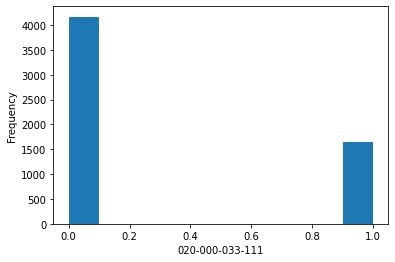

In [3]:
for i in range(7):
    plt.hist(data[:,i])
    plt.xlabel(data_raw.columns[i])
    plt.ylabel("Frequency")
    plt.show()

* *We find the mean and variance of the overall data using training set*
* *Then we find the parameter "e" using the cross-validation set*
* *We test the algorithm on test set*

In [4]:
training = correct[:3000,:]
cross_validation = np.append(correct[1500:,:],faulty[:164,:],axis=0)
testing = np.append(correct[4500:,:],faulty[164:,:],axis=0)

> **Function to calculate the gaussian column wise. We make different Gaussian fo reach feature**

In [5]:
def mean_column(array):
    mean = 0
    m=[]
    for i in range(array.shape[1]):
        mean=0
        for j in range(array.shape[0]):
            mean+=array[j][i]
        mean = mean/(array.shape[0])
        m.append(mean)
    return np.array(m)

def variance_column(array,mean):
    variance=0
    s=[]
    for i in range(array.shape[1]):
        variance=0
        for j in range(array.shape[0]):
            variance+=(array[j][i] - mean[i])**2
        variance/=array.shape[0]
        s.append(variance)
    return np.array(s)

def gaussian(array,mean,std):
    p = []
    for i in range(array.shape[0]):
        tmp=1
        for j in range(array.shape[1]):
            tmp*=(np.exp(-((array[i][j]-mean[j])**2)/(2*(std[j])**2)))/(((2*np.pi)**0.5)*std[j])
        p.append(tmp)
    return p

* **m : no of training examples**
* **n : no of features**
* **Here mean and variance are list with n number of entries as they are calculated column-wise**
* **Gaussian has m entries as it is calulated for all the datapoints in the training set**

* ***We are gonna use F1 score as an evaluation metric on cross-validation dataset***

In [6]:
def precision(result,y_actual):
    false_pos=0
    true_pos=0
    for i in range(y_actual.shape[0]):
        if(result[i]==y_actual[i] and result[i]==0):
            true_pos+=1
        if(result[i]==1 and y_actual[i]==0):
            false_pos+=1
    return true_pos/(true_pos+false_pos)

def recall(result,y_actual):
    false_neg = 0
    true_pos =0
    for i in range(y_actual.shape[0]):
        if(result[i]==1 and y_actual[i]==0):
            false_neg+=1
        if(result[i]==y_actual[i] and result[i]==0):
            true_pos+=1
    return (true_pos)/(true_pos+false_neg)

def F1_score(precision_set,recall_set):
    return 2*(precision_set*recall_set)/(precision_set+recall_set)

* *Now we prepare the three datasets*

In [7]:
y_training = training[:,-1]
training = training[:,:-1]

y_cross_val = cross_validation[:,-1]
cross_val = cross_validation[:,:-1]

y_testing = testing[:,-1]
testing = testing[:,:-1]

* *We use training set to calculate mean and variance as stated above then find the gaussian on cross_validation set*

In [8]:
mean = mean_column(training)
variance = variance_column(training,mean)
gaussian_list = gaussian(cross_val,mean,variance)
print(gaussian_list[:5])

[1.8003073704316982e-06, 1.056274555250281e-13, 1.824902701473127e-06, 1.4533109703314414e-06, 1.7901689539571847e-06]


In [9]:
gauss_list = np.array(gaussian_list)
print(gauss_list[:5])
print(y_cross_val[:5])

[1.80030737e-06 1.05627456e-13 1.82490270e-06 1.45331097e-06
 1.79016895e-06]
[0. 0. 0. 0. 0.]


In [10]:
for i in range(gauss_list.shape[0]):
    if(y_cross_val[i]==1):
        print(gauss_list[i],end="  ")

1.4267818005179737e-06  8.887258525501954e-14  1.2454136115787589e-06  1.1138267624040221e-06  1.5765649425227305e-06  1.2588573403158833e-06  9.641194576007505e-07  1.560157027410913e-06  9.777799307946836e-14  1.2863201787373163e-06  1.5909159757292334e-06  1.400840142724348e-06  8.88584531174913e-07  1.1114771256093227e-06  8.16084374161439e-14  1.14853592993048e-06  6.108484966020907e-07  1.104884147858856e-06  1.3289274489424696e-06  9.270848713299201e-07  1.1972523769116592e-06  8.783849672122493e-14  1.2226444875991963e-06  1.1285863502380445e-06  1.4477146614537632e-06  1.3582871857350355e-06  1.1462391667706807e-06  1.7454493796771884e-06  1.0632682984766218e-13  1.782716528798969e-06  2.9589393712440845e-08  2.003723251859717e-08  2.3040202103893796e-15  1.63862735148832e-08  1.0700731628177661e-08  3.4866385013765374e-08  2.157707663824982e-08  1.1778661229811864e-08  4.233287377908229e-08  3.921451412114445e-15  6.924118778591347e-08  1.2794396612106238e-07  6.8583385361362

* **Studying the above list, we find all the values are <=1.9*(e-6). So we can flag off values approximately below this threshold to be anomalous examples**
* So our parameter e= 2*(e-6) as its just the cross-validation set to avoid any overfitting

In [11]:
e=10**(-12)
ypred_cross_val=[]
for i in range(gauss_list.shape[0]):
    if(gauss_list[i]<e):
        ypred_cross_val.append(1)
    else:
        ypred_cross_val.append(0)
ypred_cv = np.array(ypred_cross_val)
precision_cv = precision(ypred_cv,y_cross_val)
recall_cv = recall(ypred_cv,y_cross_val)
f1_score = F1_score(precision_cv,recall_cv)
print(f1_score)

0.8504273504273504


*  ***The good F1 score is an indicator that our parameter e is well chosen***
* ***Otherwise the score would have been much less***
*  ***So even for our testing set, we can safely take the above value of e***

In [12]:
gaussian_test = gaussian(testing,mean,variance)
print(gaussian_test[:5])

[2.104418011878253e-08, 2.250820100346299e-15, 2.9154086154698142e-08, 2.6079459808135493e-08, 3.439642905875365e-08]


In [13]:
ypred_test=[]
for i in range(y_testing.shape[0]):
    if(gaussian_test[i]<e):
        ypred_test.append(1)
    else:
        ypred_test.append(0)
ypred_test = np.array(ypred_test)
p_test = precision(ypred_test,y_testing)
r_test = recall(ypred_test,y_testing)
f1score_test = F1_score(p_test,r_test)
print(f1score_test)

0.8507157464212679


* ***So here our F1 score is around 0.85 which is fairly good***
* ***Also we will try to tweek e values by reducing it by 0.1 everytime from its original value***
* ***After reducing the values the F1 score of cross_val set hardly changed, but the test set's F1 score changed greatly***
* ***So our previous value of e=(2x10^(-6)) was overfitting on cross_validating set. It was changed to 10^(-10)***